<a href="https://colab.research.google.com/github/NeDarbandsari/WSPTrafficView/blob/main/WSPFinalSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Extract the contents of dataset from zip file into the current working directory

!unzip /content/drive/MyDrive/WSPTrafficView2.zip -d dataset

Archive:  /content/drive/MyDrive/WSPTrafficView2.zip
   creating: dataset/WSPTrafficView/
  inflating: dataset/__MACOSX/._WSPTrafficView  
   creating: dataset/WSPTrafficView/valid/
  inflating: dataset/__MACOSX/WSPTrafficView/._valid  
  inflating: dataset/WSPTrafficView/.DS_Store  
  inflating: dataset/__MACOSX/WSPTrafficView/._.DS_Store  
   creating: dataset/WSPTrafficView/test/
  inflating: dataset/__MACOSX/WSPTrafficView/._test  
   creating: dataset/WSPTrafficView/train/
  inflating: dataset/__MACOSX/WSPTrafficView/._train  
  inflating: dataset/WSPTrafficView/valid/88.png  
  inflating: dataset/__MACOSX/WSPTrafficView/valid/._88.png  
  inflating: dataset/WSPTrafficView/valid/100.txt  
  inflating: dataset/__MACOSX/WSPTrafficView/valid/._100.txt  
  inflating: dataset/WSPTrafficView/valid/89.png  
  inflating: dataset/__MACOSX/WSPTrafficView/valid/._89.png  
  inflating: dataset/WSPTrafficView/valid/.DS_Store  
  inflating: dataset/__MACOSX/WSPTrafficView/valid/._.DS_Store  
  

In [3]:
# Install required dependencies

!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python matplotlib pandas scikit-learn

  Preparing metadata (setup.py) ... done


In [4]:
# Import packages

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
import os
import pandas as pd
from glob import glob
from sklearn.metrics import confusion_matrix, average_precision_score

In [5]:
# Define dataset paths

dataset_paths = {
    'train': '/content/dataset/WSPTrafficView/train',
    'valid': '/content/dataset/WSPTrafficView/valid',
    'test':  '/content/dataset/WSPTrafficView/test'
}

In [6]:
# Load SAM model

model_type = "vit_b"
sam_checkpoint = "/content/sam_vit_b_01ec64.pth"
if not os.path.exists(sam_checkpoint):
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O {sam_checkpoint}

device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

--2025-07-06 11:04:46--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.25, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘/content/sam_vit_b_01ec64.pth’

/content/sam_vit_b_ 100%[===================>] 357.67M   187MB/s    in 1.9s    

2025-07-06 11:04:48 (187 MB/s) - ‘/content/sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [7]:
# Generate predicted masks for validation set

valid_dir = dataset_paths['valid']
output_dir = "/content/sam_outputs/valid"
os.makedirs(output_dir, exist_ok=True)

valid_files = sorted([f for f in os.listdir(valid_dir) if f.endswith(".png")])

for filename in valid_files:
    image_path = os.path.join(valid_dir, filename)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor.set_image(image_rgb)

    # Use bounding box prompt for segmentation
    h, w = image.shape[:2]
    box = np.array([[w // 4, h // 4, 3 * w // 4, 3 * h // 4]])

    masks, scores, _ = predictor.predict(box=box, multimask_output=True)
    best_mask = masks[np.argmax(scores)].astype(np.uint8) * 255  # Binary mask

    output_path = os.path.join(output_dir, filename)
    Image.fromarray(best_mask).save(output_path)

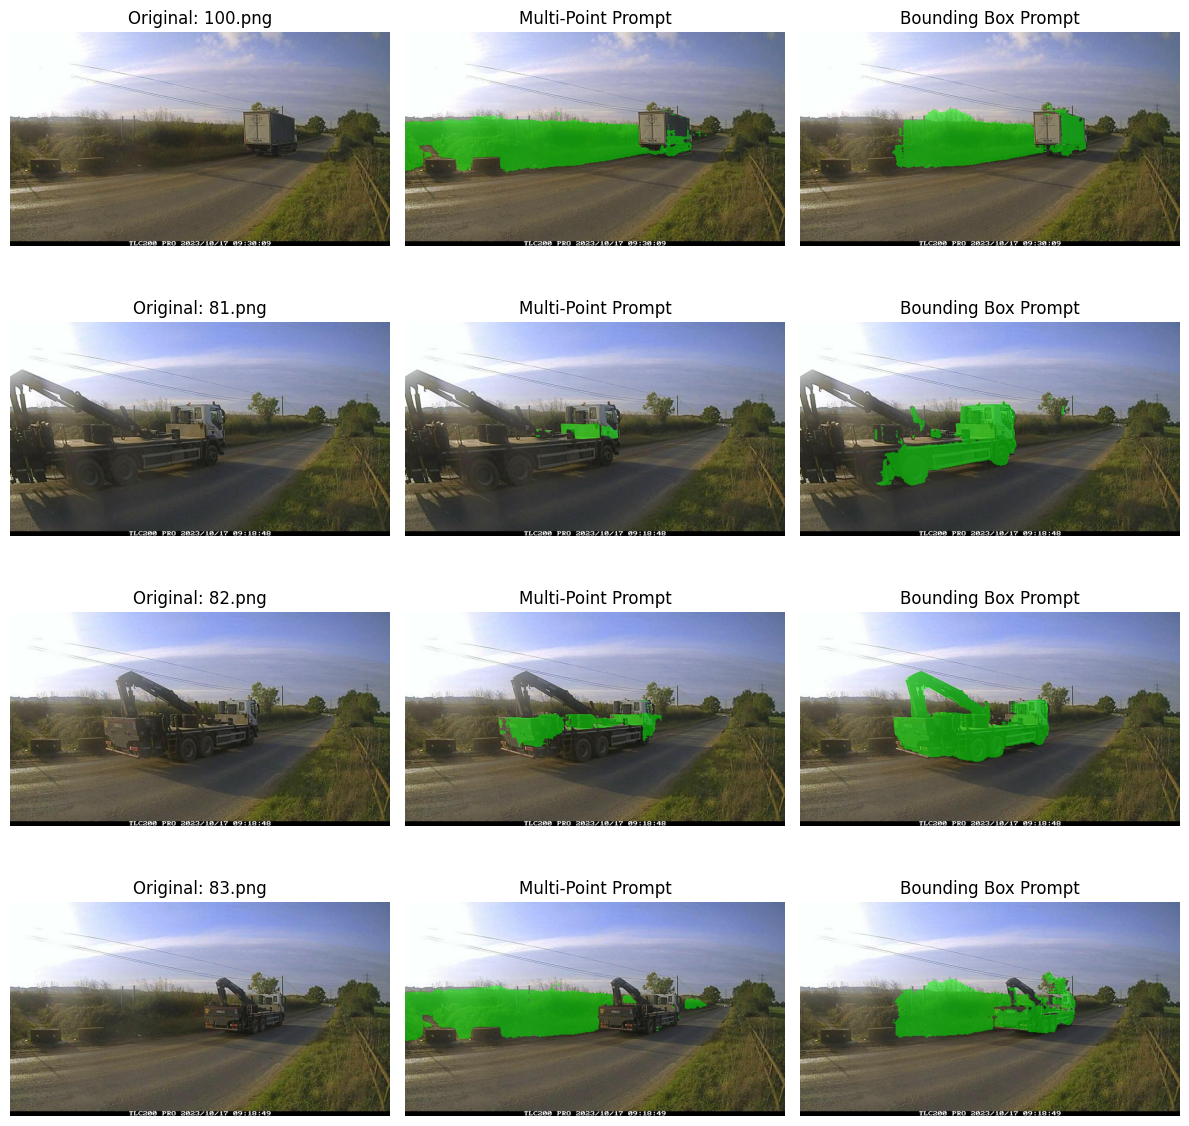

In [15]:
# Visualising the results

def overlay_mask_on_image(image, mask, color=(0, 255, 0), alpha=0.5):
    overlay = image.copy()
    overlay[mask] = (overlay[mask] * (1 - alpha) + np.array(color) * alpha).astype(np.uint8)
    return overlay

image_dir = dataset_paths['valid']
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

num_images_to_show = 4
fig, axes = plt.subplots(num_images_to_show, 3, figsize=(12, 3 * num_images_to_show))
if num_images_to_show == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, filename in enumerate(image_files[:num_images_to_show]):
    image_path = os.path.join(image_dir, filename)
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)
    h, w = image_rgb.shape[:2]

    # multi-point prompt
    input_points = np.array([
        [w // 3, h // 2],
        [w // 2, h // 2],
        [2 * w // 3, h // 2]
    ])
    input_labels = np.array([1, 1, 1])
    masks_mp, scores_mp, _ = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=True
    )
    mask_mp = masks_mp[np.argmax(scores_mp)]

    # bounding box prompt
    box = np.array([[w // 4, h // 4], [3 * w // 4, 3 * h // 4]])
    masks_bb, scores_bb, _ = predictor.predict(box=box, multimask_output=True)
    mask_bb = masks_bb[np.argmax(scores_bb)]

    # visualisation
    overlay_mp = overlay_mask_on_image(image_rgb, mask_mp)
    overlay_bb = overlay_mask_on_image(image_rgb, mask_bb)

    axes[idx, 0].imshow(image_rgb)
    axes[idx, 0].set_title(f"Original: {filename}")
    axes[idx, 1].imshow(overlay_mp)
    axes[idx, 1].set_title("Multi-Point Prompt")
    axes[idx, 2].imshow(overlay_bb)
    axes[idx, 2].set_title("Bounding Box Prompt")

    for ax in axes[idx]:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Define metric computation function

def compute_metrics(gt_mask, pred_mask, num_classes=2):
    gt = gt_mask.flatten()
    pred = pred_mask.flatten()

    cm = confusion_matrix(gt, pred, labels=list(range(num_classes)))
    intersection = np.diag(cm)
    union = np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm)
    iou = intersection / np.maximum(union, 1)
    mean_iou = np.mean(iou)

    pixel_accuracy = np.sum(intersection) / np.sum(cm)
    ap = average_precision_score(gt, pred)

    return {
        "Mean IoU (%)": 100 * mean_iou,
        "Pixel Accuracy (%)": 100 * pixel_accuracy,
        "mAP@0.5 (%)": 100 * ap
    }

In [14]:
# Evaluation metrics across validation set

gt_dir = dataset_paths['valid']
pred_dir = output_dir
all_metrics = []

for fname in valid_files:
    gt_path = os.path.join(gt_dir, fname)
    pred_path = os.path.join(pred_dir, fname)

    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    gt_mask = (gt_mask > 127).astype(np.uint8)
    pred_mask = (pred_mask > 127).astype(np.uint8)

    metrics = compute_metrics(gt_mask, pred_mask)
    all_metrics.append(metrics)

# Average metrics

df = pd.DataFrame(all_metrics)
avg_metrics = df.mean().to_frame().T

print("\n       Average Segmentation Evaluation Metrics\n")
print(avg_metrics.to_markdown(index=False))


       Average Segmentation Evaluation Metrics

|   Mean IoU (%) |   Pixel Accuracy (%) |   mAP@0.5 (%) |
|---------------:|---------------------:|--------------:|
|        28.0078 |              55.0745 |       37.7819 |


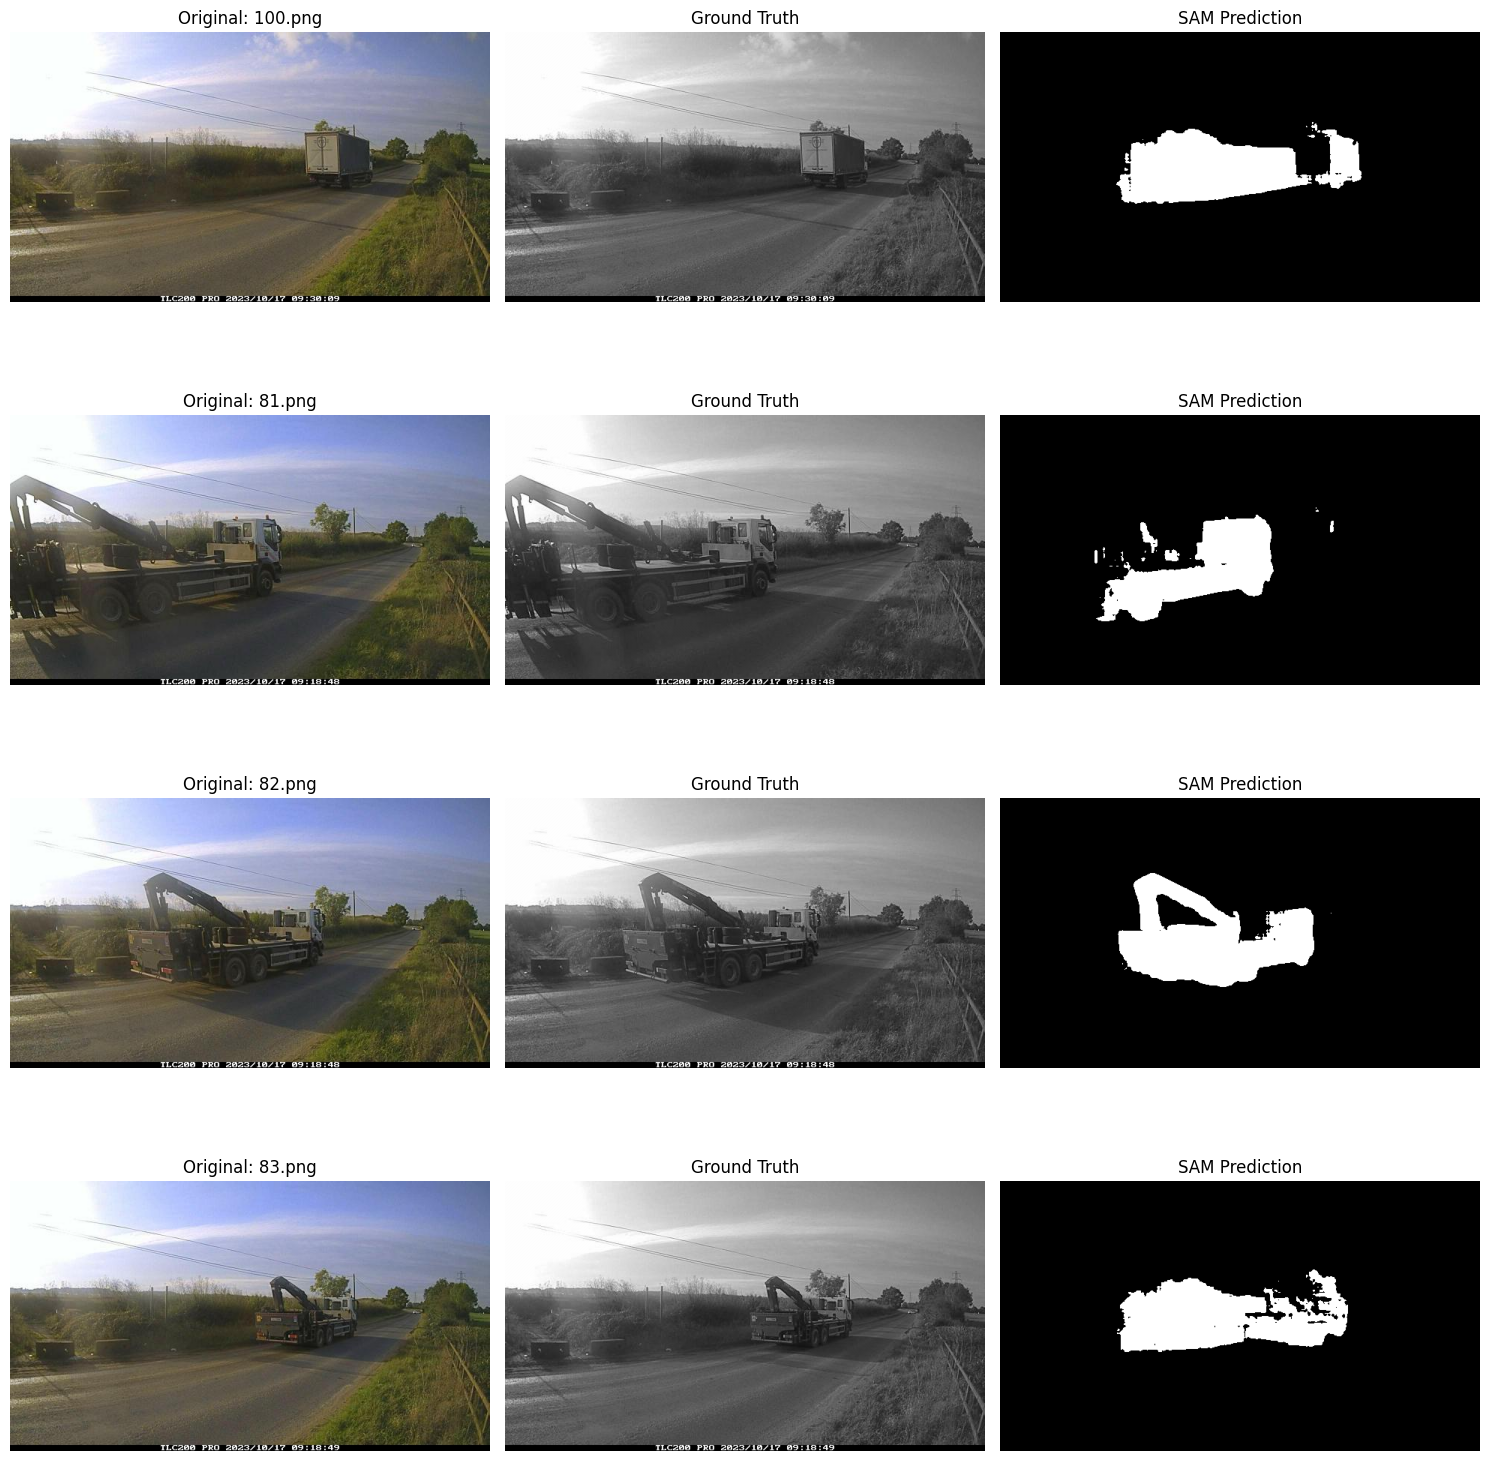

In [16]:
# Show original, ground truth, and prediction

sample_images = valid_files[:4]

plt.figure(figsize=(15, 4 * len(sample_images)))
for i, fname in enumerate(sample_images):
    image = cv2.imread(os.path.join(valid_dir, fname))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(os.path.join(valid_dir, fname), cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(os.path.join(output_dir, fname), cv2.IMREAD_GRAYSCALE)

    plt.subplot(len(sample_images), 3, i * 3 + 1)
    plt.imshow(image)
    plt.title(f"Original: {fname}")
    plt.axis('off')

    plt.subplot(len(sample_images), 3, i * 3 + 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(len(sample_images), 3, i * 3 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("SAM Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


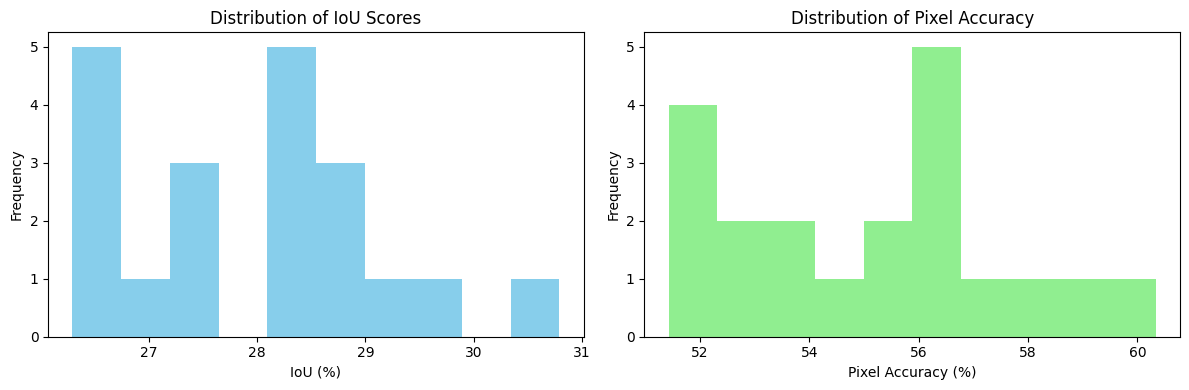

In [28]:
# Histogram of IoU or Accuracy

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Mean IoU (%)'], bins=10, color='skyblue')
plt.title("Distribution of IoU Scores")
plt.xlabel("IoU (%)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df['Pixel Accuracy (%)'], bins=10, color='lightgreen')
plt.title("Distribution of Pixel Accuracy")
plt.xlabel("Pixel Accuracy (%)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()